In [1]:
import numpy
import pandas

from toposample import config
from toposample import TopoData
from toposample.data import read_h5_dataset

from figure_helper import FigureHelper


cfg_file = "../working_dir/config/common_config.json"
cfg = config.Config(cfg_file)

stage = cfg.stage("count_triads")
fn_triads = stage["outputs"]["triads"]  # Triad over- and under-expression

stage = cfg.stage("classifier")
fn_components = stage["outputs"]["classifier_components_results"]  # accuracy for component-based
fn_features = stage["outputs"]["classifier_features_results"]  # accuracy for feature-based

stage = cfg.stage("gen_topo_db")
fn_db = stage["outputs"]["database"]

stage = cfg.stage("struc_tribe_analysis")
fn_struc_params = stage["outputs"]["struc_parameters"]

stage = cfg.stage("sample_tribes")
fn_gids = stage["outputs"]["tribes"]

S = FigureHelper()("Figure S6")

In [2]:
triads = TopoData(fn_triads)["overexpression"].map(numpy.array)
acc_components = TopoData(fn_components,
                   follow_link_functions={"data_fn": [read_h5_dataset("scores"), False]})["data_fn"]
acc_features = TopoData(fn_features,
                   follow_link_functions={"data_fn": [read_h5_dataset("scores"), False]})["data_fn"]
db = pandas.read_pickle(fn_db)
gids = TopoData(fn_gids)["gids"]
struc_params = TopoData(fn_struc_params)
struc_params.data["Mean tribe community coupling"] =\
gids.map(lambda x: numpy.nanmean(db["comm_coupling"].loc[x]))

<ipython-input-2-ce1b23591f9b>:10: RuntimeWarning: Mean of empty slice
  gids.map(lambda x: numpy.nanmean(db["comm_coupling"].loc[x]))


<ipython-input-3-fca0f3e843c9>:12: RuntimeWarning: invalid value encountered in true_divide
  triad_rel_er = triads.map(lambda x: (1E-6 + x[0] / x[0].sum()) / (1E-6 + x[1] / x[1].sum()))


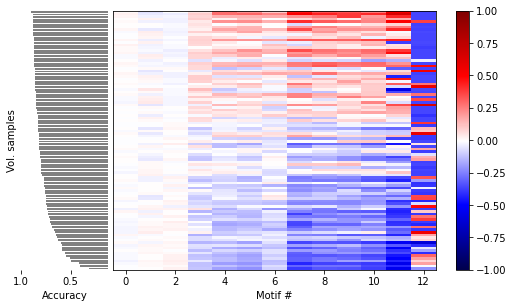

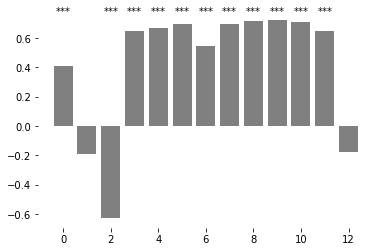

In [3]:
"""
Figure panel: For the volumetric case: Over- and under-expression sorted by accuracy
"""
from matplotlib import pyplot as plt
from scipy.stats import pearsonr

mean_acc_components = acc_components.map(numpy.nanmean)
index, radius, acc_val = mean_acc_components.get_x_y(["index", "specifier"], sampling="Radius")
idxx = numpy.argsort(acc_val)

plot_acc_vals = [acc_val[i] for i in idxx]
triad_rel_er = triads.map(lambda x: (1E-6 + x[0] / x[0].sum()) / (1E-6 + x[1] / x[1].sum()))
plot_profiles = numpy.vstack([triad_rel_er.get2(sampling="Radius",
                                                specifier=radius[i],
                                                index=index[i]) 
                              for i in idxx])
plot_mean = plot_profiles.mean(axis=0, keepdims=True)
plot_profiles = (plot_profiles - plot_mean) / (plot_profiles + plot_mean)  # normalized between 0 and 1

fig = plt.figure(figsize=(8, 4.5))
ax = fig.add_axes([0.05, 0.1, 0.15, 0.8])
ax.barh(range(len(plot_acc_vals)), plot_acc_vals, color='grey', height=0.75)
ax.set_xlim([1, 0.125])
ax.set_ylim([-0.5, len(plot_acc_vals) - 0.5])
ax.set_yticks([])
ax.set_ylabel("Vol. samples")
ax.set_xlabel("Accuracy")
plt.box(False)

ax = fig.add_axes([0.21, 0.1, 0.7, 0.8])
img = ax.imshow(plot_profiles, aspect='auto', cmap='seismic', interpolation='nearest')
ax.set_yticks([])
img.set_clim([-1, 1])
ax.set_ylim([-0.5, len(plot_acc_vals) - 0.5])
plt.colorbar(img)
ax.set_xlabel("Motif #")

S.save(fig, "Panel-triads-accuracyA")

motif_corr = numpy.vstack([pearsonr(plot_acc_vals, motif) for motif in plot_profiles.transpose()])
fig = plt.figure()
ax = fig.gca()
ax.bar(range(len(motif_corr)), motif_corr[:, 0], color='grey')
for i, pval in enumerate(motif_corr[:, 1]):
    if pval <= 0.01:
        mrk = '*'
        if pval <= 0.001:
            mrk = '**'
            if pval <= 0.0001:
                mrk = '***'
        ax.text(i, 0.76, mrk, horizontalalignment='center')
plt.box(False)

S.save(fig, "Panel-triads-accuracyB")

<ipython-input-4-130fb03b57dc>:8: RuntimeWarning: invalid value encountered in true_divide
  triad_rel_expected = triads.map(lambda x: (1E-6 + x[0] / x[0].sum()) / (1E-6 + x[1] / x[1].sum()))


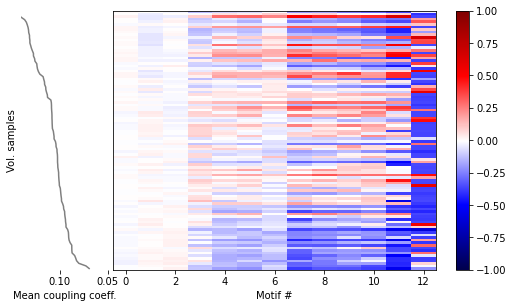

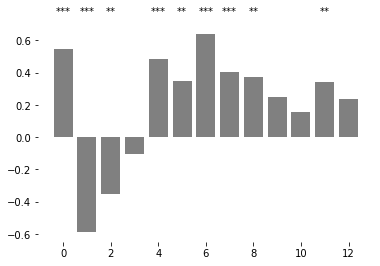

In [4]:
community_coupling = struc_params["Mean tribe community coupling"]

index, radius, cc_val = community_coupling.get_x_y(["index", "specifier"], sampling="Radius")
idxx = numpy.argsort(cc_val)
idxx = [i for i in idxx if not numpy.isnan(cc_val[i])]

plot_cc_vals = [cc_val[i] for i in idxx]
triad_rel_expected = triads.map(lambda x: (1E-6 + x[0] / x[0].sum()) / (1E-6 + x[1] / x[1].sum()))
plot_profiles = [triad_rel_expected.get2(sampling="Radius",
                                                specifier=radius[i],
                                                index=index[i]) 
                              for i in idxx]
plot_profiles = numpy.array([x if len(x) > 0 else [1.0] * len(plot_profiles[0])
                             for x in plot_profiles])

plot_mean = numpy.nanmean(plot_profiles, axis=0, keepdims=True)
plot_profiles = (plot_profiles - plot_mean) / (plot_profiles + plot_mean)  # normalized between 0 and 1

fig = plt.figure(figsize=(8, 4.5))
ax = fig.add_axes([0.05, 0.1, 0.15, 0.8])
ax.plot(plot_cc_vals, range(len(plot_cc_vals)), color='grey')
ax.set_xlim([0.14, 0.05])
ax.set_ylim([-0.5, len(plot_cc_vals) - 0.5])
ax.set_yticks([])
ax.set_ylabel("Vol. samples")
ax.set_xlabel("Mean coupling coeff.")
plt.box(False)

ax = fig.add_axes([0.21, 0.1, 0.7, 0.8])
img = ax.imshow(plot_profiles, aspect='auto', cmap='seismic', interpolation='nearest')
ax.set_yticks([])
img.set_clim([-1, 1])
ax.set_ylim([-0.5, len(plot_cc_vals) - 0.5])
plt.colorbar(img)
ax.set_xlabel("Motif #")

S.save(fig, "Panel-triads-couplingA")

motif_corr = numpy.vstack([pearsonr(plot_cc_vals, motif) for motif in plot_profiles.transpose()])
fig = plt.figure()
ax = fig.gca()
ax.bar(range(len(motif_corr)), motif_corr[:, 0], color='grey')
for i, pval in enumerate(motif_corr[:, 1]):
    if pval <= 0.01:
        mrk = '*'
        if pval <= 0.001:
            mrk = '**'
            if pval <= 0.0001:
                mrk = '***'
        ax.text(i, 0.76, mrk, horizontalalignment='center')
plt.box(False)

S.save(fig, "Panel-triads-couplingB")